In [143]:
# importing necessary Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [60]:
# Lets now Load the dataset 

sb_data = pd.read_csv('C:/Lohit/New folder/Updated_Starbucks_Order_Data_with_Missing_Values.csv')

sb_data.head()

,worker_id,department,location,order_detail,shift,season,detailed_order,office_location,assigned_starbucks,adjusted_order_time,adjusted_pickup_time,prep_time_minutes,time_slot,expected_wait_time_minutes
0,1,Sales,Starbucks_2,Latte - Oat Milk - Sweetener - Large - Caramel...,Morning,Fall,Small - Almond Milk - Extra Sweetener - Flavor...,Office_E,Starbucks_3,2025-03-08 08:57:00,2025-03-08 09:10:00,4.0,Morning Rush (8:00 AM - 10:00 AM),6
1,2,Marketing,Starbucks_3,Frappuccino - Soy Milk - Extra Sweetener - Med...,Evening,Fall,Large - Almond Milk - Sweetener - None,Office_E,Starbucks_3,2025-03-08 16:26:00,2025-03-08 16:32:00,5.0,Midday (10:00 AM - 12:00 PM),6
2,3,Engineering,Starbucks_1,Latte - Coconut Milk - Extra Sweetener - Small...,Morning,Winter,Small - Regular - No Sugar - None,Office_E,Starbucks_3,2025-03-08 09:42:00,2025-03-08 09:54:00,4.0,NaN,6
3,4,Support,Starbucks_2,Latte - Coconut Milk - Sweetener - Small - None,Evening,Winter,Large - Regular - Extra Sweetener - None,Office_A,Starbucks_2,2025-03-08 16:52:00,2025-03-08 17:11:00,3.0,Afternoon (12:00 PM - 2:00 PM),5
4,5,Finance,Starbucks_2,Mocha - Regular - Sweetener - Large - Flavored...,Evening,Summer,Small - Oat Milk - No Sugar - None,Office_A,Starbucks_1,2025-03-08 16:57:00,2025-03-08 17:14:00,5.0,Afternoon (12:00 PM - 2:00 PM),7


 Lets have a Look at the data

In [36]:
print(sb_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   worker_id                   10000 non-null  int64  
 1   department                  10000 non-null  object 
 2   location                    10000 non-null  object 
 3   order_detail                9000 non-null   object 
 4   shift                       10000 non-null  object 
 5   season                      9000 non-null   object 
 6   detailed_order              10000 non-null  object 
 7   office_location             10000 non-null  object 
 8   assigned_starbucks          10000 non-null  object 
 9   adjusted_order_time         10000 non-null  object 
 10  adjusted_pickup_time        9300 non-null   object 
 11  prep_time_minutes           9500 non-null   float64
 12  time_slot                   9500 non-null   object 
 13  expected_wait_time_minutes  1000

We can see that the data types of adjusted_order_time and adjusted_pickup_time are object but is should be having datetime data type.
Let's 1st change the data types and then we can proceed with handling the missing values.

In [61]:
sb_data['adjusted_order_time'] = pd.to_datetime(sb_data['adjusted_order_time'], errors='coerce')
sb_data['adjusted_pickup_time'] = pd.to_datetime(sb_data['adjusted_pickup_time'], errors='coerce')

print(sb_data.dtypes)

worker_id                              int64
department                            object
location                              object
order_detail                          object
shift                                 object
season                                object
detailed_order                        object
office_location                       object
assigned_starbucks                    object
adjusted_order_time           datetime64[ns]
adjusted_pickup_time          datetime64[ns]
prep_time_minutes                    float64
time_slot                             object
expected_wait_time_minutes             int64
dtype: object


Let's see the Null values in each column

In [43]:
print(sb_data.isnull().sum().sort_values(ascending=False))

null_values = sb_data.isnull().sum().sum()

print('\n Total Null values in the data are:',null_values)

season                        1000
order_detail                  1000
adjusted_pickup_time           700
prep_time_minutes              500
time_slot                      500
department                       0
shift                            0
location                         0
worker_id                        0
detailed_order                   0
adjusted_order_time              0
assigned_starbucks               0
office_location                  0
expected_wait_time_minutes       0
dtype: int64

 Total Null values in the data are: 3700


Let's now check the missing values in each row

In [27]:
null_mask = sb_data.isnull()

null_counts = null_mask.sum(axis=1)

rows_with_null = sb_data[null_counts >= 2]

print(rows_with_null.count(1).count())

458


In [62]:
def impute_time_slot(row):
    if pd.isna(row['time_slot']):
        hour = row['adjusted_order_time'].hour
        if 8 <= hour <10:
            return 'Morning Rush (8:00 AM - 10:00 AM)'
        elif 10<= hour <12:
            return 'Midday (10:00 AM - 12:00 PM)'
        elif 12 <= hour < 14:
            return 'Afternoon (12:00 PM - 2:00 PM)'
        elif 14 <= hour < 16:
            return 'Afternoon (2:00 PM - 4:00 PM)'
        elif 16 <= hour < 18:
            return 'Evening (4:00 PM - 6:00 PM)'
        else:
            return 'Late Evening (6:00 PM - 8:00 PM)'
    return row['time_slot']

sb_data['time_slot'] = sb_data.apply(impute_time_slot,axis=1)

print(sb_data.isnull().sum().sort_values(ascending=False))

season                        1000
order_detail                  1000
adjusted_pickup_time           700
prep_time_minutes              500
department                       0
worker_id                        0
shift                            0
location                         0
detailed_order                   0
office_location                  0
adjusted_order_time              0
assigned_starbucks               0
time_slot                        0
expected_wait_time_minutes       0
dtype: int64


In [63]:
prep_time_median = sb_data['prep_time_minutes'].median()
sb_data['prep_time_minutes'] = sb_data['prep_time_minutes'].fillna(prep_time_median)

# Impute 'adjusted_pickup_time' by adding 'prep_time_minutes' to 'adjusted_order_time'
sb_data['adjusted_pickup_time'] = sb_data.apply(
    lambda row: row['adjusted_order_time'] + pd.to_timedelta(row['prep_time_minutes'], unit='m')
    if pd.isnull(row['adjusted_pickup_time']) else row['adjusted_pickup_time'], axis=1
)

season_mode = sb_data['season'].mode()[0]
sb_data['season'] = sb_data['season'].fillna(season_mode)

print(sb_data.isnull().sum().sort_values(ascending=False))

order_detail                  1000
worker_id                        0
department                       0
location                         0
shift                            0
season                           0
detailed_order                   0
office_location                  0
assigned_starbucks               0
adjusted_order_time              0
adjusted_pickup_time             0
prep_time_minutes                0
time_slot                        0
expected_wait_time_minutes       0
dtype: int64


In [66]:
clean_data = sb_data.drop(columns='order_detail')

print('\n',clean_data.shape)
print('\n',clean_data.info())


 (10000, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   worker_id                   10000 non-null  int64         
 1   department                  10000 non-null  object        
 2   location                    10000 non-null  object        
 3   shift                       10000 non-null  object        
 4   season                      10000 non-null  object        
 5   detailed_order              10000 non-null  object        
 6   office_location             10000 non-null  object        
 7   assigned_starbucks          10000 non-null  object        
 8   adjusted_order_time         10000 non-null  datetime64[ns]
 9   adjusted_pickup_time        10000 non-null  datetime64[ns]
 10  prep_time_minutes           10000 non-null  float64       
 11  time_slot                   10000 non-nul

In [88]:
clean_data.to_excel('Cleaned_starbucks_data.xlsx')

In [92]:
time_slot_mapping = {
    'Morning Rush (8:00 AM - 10:00 AM)': 'Morning (8:00 AM - 12:00 pm)',
    'Midday (10:00 AM - 12:00 PM)': 'Morning (8:00 AM - 12:00 pm)',
    'Afternoon (12:00 PM - 2:00 PM)': 'Afternoon (12:00 PM - 4:00 PM)',
    'Late Afternoon (2:00 PM - 4:00 PM)': 'Afternoon (12:00 PM - 4:00 PM)',
    'Evening (4:00 PM - 6:00 PM)': 'Evening (4:00 PM - 6:00 PM)',
    'Late Evening (6:00 PM - 8:00 PM)': 'Night (6:00 PM - 8:00 PM)',
}

clean_data['simplified_time_slot'] = clean_data['time_slot'].map(time_slot_mapping)

clean_data.head()

,worker_id,department,location,shift,season,detailed_order,office_location,assigned_starbucks,adjusted_order_time,adjusted_pickup_time,prep_time_minutes,time_slot,expected_wait_time_minutes,simplified_time_slot
0,1,Sales,Starbucks_2,Morning,Fall,Small - Almond Milk - Extra Sweetener - Flavor...,Office_E,Starbucks_3,2025-03-08 08:57:00,2025-03-08 09:10:00,4.0,Morning Rush (8:00 AM - 10:00 AM),6,Morning (8:00 AM - 12:00 pm)
1,2,Marketing,Starbucks_3,Evening,Fall,Large - Almond Milk - Sweetener - None,Office_E,Starbucks_3,2025-03-08 16:26:00,2025-03-08 16:32:00,5.0,Midday (10:00 AM - 12:00 PM),6,Morning (8:00 AM - 12:00 pm)
2,3,Engineering,Starbucks_1,Morning,Winter,Small - Regular - No Sugar - None,Office_E,Starbucks_3,2025-03-08 09:42:00,2025-03-08 09:54:00,4.0,Morning Rush (8:00 AM - 10:00 AM),6,Morning (8:00 AM - 12:00 pm)
3,4,Support,Starbucks_2,Evening,Winter,Large - Regular - Extra Sweetener - None,Office_A,Starbucks_2,2025-03-08 16:52:00,2025-03-08 17:11:00,3.0,Afternoon (12:00 PM - 2:00 PM),5,Afternoon (12:00 PM - 4:00 PM)
4,5,Finance,Starbucks_2,Evening,Summer,Small - Oat Milk - No Sugar - None,Office_A,Starbucks_1,2025-03-08 16:57:00,2025-03-08 17:14:00,5.0,Afternoon (12:00 PM - 2:00 PM),7,Afternoon (12:00 PM - 4:00 PM)


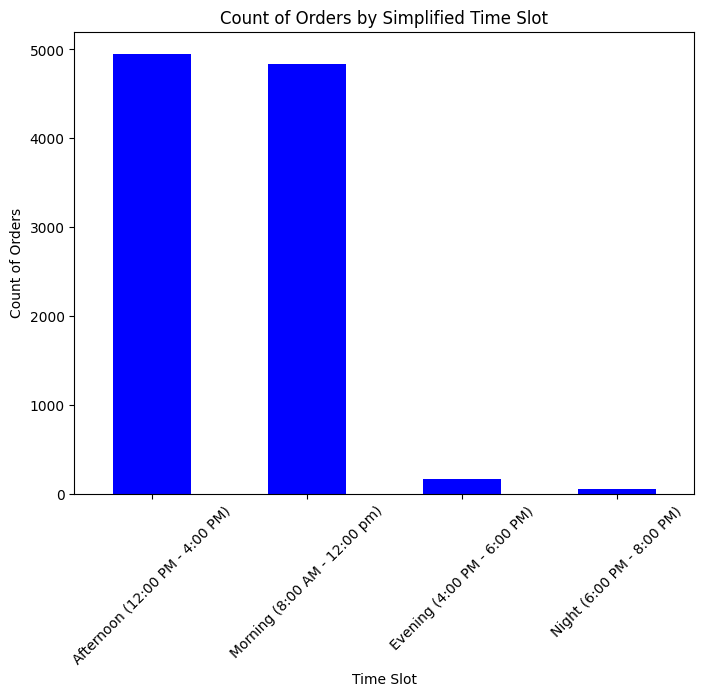

In [100]:
# Get the value counts for 'simplified_time_slot'
simplified_time_slot_counts = clean_data['simplified_time_slot'].value_counts()

# Plotting the value counts of 'simplified_time_slot'
plt.figure(figsize=(8, 6))
simplified_time_slot_counts.plot(kind='bar', color='blue')
plt.title('Count of Orders by Simplified Time Slot')
plt.xlabel('Time Slot')
plt.ylabel('Count of Orders')
plt.xticks(rotation=45)
plt.show()


In [102]:
clean_data = clean_data.drop(columns=['prep_time_minutes','expected_wait_time_minutes'])

clean_data.head()

,worker_id,department,location,shift,season,detailed_order,office_location,assigned_starbucks,adjusted_order_time,adjusted_pickup_time,time_slot,simplified_time_slot
0,1,Sales,Starbucks_2,Morning,Fall,Small - Almond Milk - Extra Sweetener - Flavor...,Office_E,Starbucks_3,2025-03-08 08:57:00,2025-03-08 09:10:00,Morning Rush (8:00 AM - 10:00 AM),Morning (8:00 AM - 12:00 pm)
1,2,Marketing,Starbucks_3,Evening,Fall,Large - Almond Milk - Sweetener - None,Office_E,Starbucks_3,2025-03-08 16:26:00,2025-03-08 16:32:00,Midday (10:00 AM - 12:00 PM),Morning (8:00 AM - 12:00 pm)
2,3,Engineering,Starbucks_1,Morning,Winter,Small - Regular - No Sugar - None,Office_E,Starbucks_3,2025-03-08 09:42:00,2025-03-08 09:54:00,Morning Rush (8:00 AM - 10:00 AM),Morning (8:00 AM - 12:00 pm)
3,4,Support,Starbucks_2,Evening,Winter,Large - Regular - Extra Sweetener - None,Office_A,Starbucks_2,2025-03-08 16:52:00,2025-03-08 17:11:00,Afternoon (12:00 PM - 2:00 PM),Afternoon (12:00 PM - 4:00 PM)
4,5,Finance,Starbucks_2,Evening,Summer,Small - Oat Milk - No Sugar - None,Office_A,Starbucks_1,2025-03-08 16:57:00,2025-03-08 17:14:00,Afternoon (12:00 PM - 2:00 PM),Afternoon (12:00 PM - 4:00 PM)


In [103]:
clean_data['order_time'] = clean_data['adjusted_order_time'].dt.time
clean_data['pickup_time'] = clean_data['adjusted_pickup_time'].dt.time

clean_data = clean_data.drop(columns=['adjusted_order_time','adjusted_pickup_time'])

print('\n',clean_data.shape)
print('\n',clean_data.head())



 (10000, 12)

    worker_id   department     location    shift  season  \
0          1        Sales  Starbucks_2  Morning    Fall   
1          2    Marketing  Starbucks_3  Evening    Fall   
2          3  Engineering  Starbucks_1  Morning  Winter   
3          4      Support  Starbucks_2  Evening  Winter   
4          5      Finance  Starbucks_2  Evening  Summer   

                                      detailed_order office_location  \
0  Small - Almond Milk - Extra Sweetener - Flavor...        Office_E   
1             Large - Almond Milk - Sweetener - None        Office_E   
2                  Small - Regular - No Sugar - None        Office_E   
3           Large - Regular - Extra Sweetener - None        Office_A   
4                 Small - Oat Milk - No Sugar - None        Office_A   

  assigned_starbucks                          time_slot  \
0        Starbucks_3  Morning Rush (8:00 AM - 10:00 AM)   
1        Starbucks_3       Midday (10:00 AM - 12:00 PM)   
2        Starbucks_

In [105]:
clean_data = clean_data.drop(columns=['time_slot'])

clean_data.head()

,worker_id,department,location,shift,season,detailed_order,office_location,assigned_starbucks,simplified_time_slot,order_time,pickup_time
0,1,Sales,Starbucks_2,Morning,Fall,Small - Almond Milk - Extra Sweetener - Flavor...,Office_E,Starbucks_3,Morning (8:00 AM - 12:00 pm),08:57:00,09:10:00
1,2,Marketing,Starbucks_3,Evening,Fall,Large - Almond Milk - Sweetener - None,Office_E,Starbucks_3,Morning (8:00 AM - 12:00 pm),16:26:00,16:32:00
2,3,Engineering,Starbucks_1,Morning,Winter,Small - Regular - No Sugar - None,Office_E,Starbucks_3,Morning (8:00 AM - 12:00 pm),09:42:00,09:54:00
3,4,Support,Starbucks_2,Evening,Winter,Large - Regular - Extra Sweetener - None,Office_A,Starbucks_2,Afternoon (12:00 PM - 4:00 PM),16:52:00,17:11:00
4,5,Finance,Starbucks_2,Evening,Summer,Small - Oat Milk - No Sugar - None,Office_A,Starbucks_1,Afternoon (12:00 PM - 4:00 PM),16:57:00,17:14:00


Dropped prep_time_minutes and expected_wait_time_minutes since it does'nt make any sense. converted the adjusted_order_time and adjusted_pickup_time into only time format so that it will be easy for modeling. Dropped time slot since we have the simplified_time_slot.


In [126]:
final_data = clean_data.copy()

final_data.head()

,worker_id,department,location,shift,season,detailed_order,office_location,assigned_starbucks,simplified_time_slot,order_time,pickup_time
0,1,Sales,Starbucks_2,Morning,Fall,Small - Almond Milk - Extra Sweetener - Flavor...,Office_E,Starbucks_3,Morning (8:00 AM - 12:00 pm),08:57:00,09:10:00
1,2,Marketing,Starbucks_3,Evening,Fall,Large - Almond Milk - Sweetener - None,Office_E,Starbucks_3,Morning (8:00 AM - 12:00 pm),16:26:00,16:32:00
2,3,Engineering,Starbucks_1,Morning,Winter,Small - Regular - No Sugar - None,Office_E,Starbucks_3,Morning (8:00 AM - 12:00 pm),09:42:00,09:54:00
3,4,Support,Starbucks_2,Evening,Winter,Large - Regular - Extra Sweetener - None,Office_A,Starbucks_2,Afternoon (12:00 PM - 4:00 PM),16:52:00,17:11:00
4,5,Finance,Starbucks_2,Evening,Summer,Small - Oat Milk - No Sugar - None,Office_A,Starbucks_1,Afternoon (12:00 PM - 4:00 PM),16:57:00,17:14:00


In [127]:
final_data = final_data.drop(columns=['simplified_time_slot'])

final_data.head()

,worker_id,department,location,shift,season,detailed_order,office_location,assigned_starbucks,order_time,pickup_time
0,1,Sales,Starbucks_2,Morning,Fall,Small - Almond Milk - Extra Sweetener - Flavor...,Office_E,Starbucks_3,08:57:00,09:10:00
1,2,Marketing,Starbucks_3,Evening,Fall,Large - Almond Milk - Sweetener - None,Office_E,Starbucks_3,16:26:00,16:32:00
2,3,Engineering,Starbucks_1,Morning,Winter,Small - Regular - No Sugar - None,Office_E,Starbucks_3,09:42:00,09:54:00
3,4,Support,Starbucks_2,Evening,Winter,Large - Regular - Extra Sweetener - None,Office_A,Starbucks_2,16:52:00,17:11:00
4,5,Finance,Starbucks_2,Evening,Summer,Small - Oat Milk - No Sugar - None,Office_A,Starbucks_1,16:57:00,17:14:00


In [128]:
final_data.dtypes

worker_id              int64
department            object
location              object
shift                 object
season                object
detailed_order        object
office_location       object
assigned_starbucks    object
order_time            object
pickup_time           object
dtype: object

In [129]:
final_data['order_time'] = pd.to_datetime(final_data['order_time'], format='%H:%M:%S')
final_data['pickup_time'] = pd.to_datetime(final_data['pickup_time'], format='%H:%M:%S')

final_data['wait_time'] = (final_data['pickup_time'] - final_data['order_time']).dt.total_seconds()/60

final_data.head()

,worker_id,department,location,shift,season,detailed_order,office_location,assigned_starbucks,order_time,pickup_time,wait_time
0,1,Sales,Starbucks_2,Morning,Fall,Small - Almond Milk - Extra Sweetener - Flavor...,Office_E,Starbucks_3,1900-01-01 08:57:00,1900-01-01 09:10:00,13.0
1,2,Marketing,Starbucks_3,Evening,Fall,Large - Almond Milk - Sweetener - None,Office_E,Starbucks_3,1900-01-01 16:26:00,1900-01-01 16:32:00,6.0
2,3,Engineering,Starbucks_1,Morning,Winter,Small - Regular - No Sugar - None,Office_E,Starbucks_3,1900-01-01 09:42:00,1900-01-01 09:54:00,12.0
3,4,Support,Starbucks_2,Evening,Winter,Large - Regular - Extra Sweetener - None,Office_A,Starbucks_2,1900-01-01 16:52:00,1900-01-01 17:11:00,19.0
4,5,Finance,Starbucks_2,Evening,Summer,Small - Oat Milk - No Sugar - None,Office_A,Starbucks_1,1900-01-01 16:57:00,1900-01-01 17:14:00,17.0


In [130]:
final_data.dtypes

worker_id                      int64
department                    object
location                      object
shift                         object
season                        object
detailed_order                object
office_location               object
assigned_starbucks            object
order_time            datetime64[ns]
pickup_time           datetime64[ns]
wait_time                    float64
dtype: object

Mean Absolute Error: 4.03617661904762
Mean Squared Error: 22.039026964106007
R² Score: -0.057983167945045766


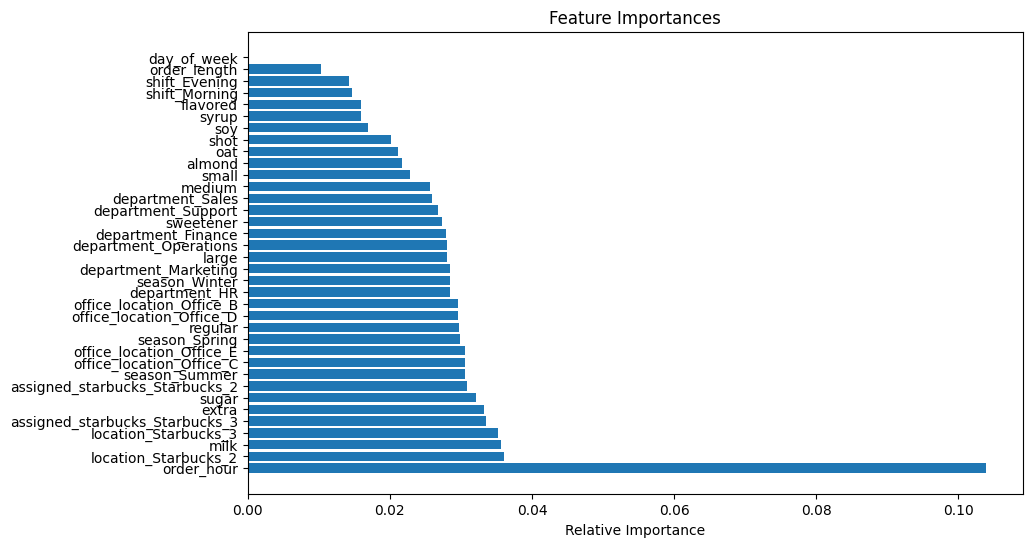

In [142]:
df = final_data.copy()


# Feature Engineering: Extract hour and other features from 'adjusted_order_time'
df['order_hour'] = pd.to_datetime(df['order_time']).dt.hour
df['day_of_week'] = pd.to_datetime(df['order_time']).dt.weekday
df['order_length'] = df['detailed_order'].apply(lambda x: len(x.split()))  # Number of customizations

# Use TF-IDF Vectorization for detailed_order
vectorizer = TfidfVectorizer(stop_words='english')
order_detail_tfidf = vectorizer.fit_transform(df['detailed_order'].fillna(''))

# Convert the sparse matrix to a DataFrame
order_detail_df = pd.DataFrame(order_detail_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Merge this new DataFrame with the original DataFrame
df = pd.concat([df, order_detail_df], axis=1)

# Drop the original 'detailed_order' column now that it's vectorized
df = df.drop(columns=['detailed_order'])

# Encode categorical variables (One-Hot Encoding)
df = pd.get_dummies(df, columns=['department', 'location', 'shift', 'season', 'office_location', 'assigned_starbucks'], drop_first=True)

# Define features (X) and target (y)
X = df.drop(columns=['wait_time', 'order_time', 'pickup_time', 'worker_id'])  # Drop non-relevant columns
y = df['wait_time']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestRegressor Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

# Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(X_train.shape[1]), importances[indices], align="center")
plt.yticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [144]:
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Use GridSearchCV to tune hyperparameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print(f"Best Parameters: {grid_search.best_params_}")

# Evaluate the best model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [145]:
# Initialize the RandomForest model with the best parameters
best_rf = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=1, random_state=42)

# Train the model
best_rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_best_rf = best_rf.predict(X_test)

# Performance Metrics
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print(f"Optimized Random Forest Mean Absolute Error: {mae_best_rf}")
print(f"Optimized Random Forest Mean Squared Error: {mse_best_rf}")
print(f"Optimized Random Forest R² Score: {r2_best_rf}")

Optimized Random Forest Mean Absolute Error: 3.9681338960355617
Optimized Random Forest Mean Squared Error: 20.953963680530247
Optimized Random Forest R² Score: -0.005894720844001


In [147]:
import xgboost as xgb

# Initialize and train the XGBoost model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Mean Absolute Error: {mae_xgb}")
print(f"XGBoost Mean Squared Error: {mse_xgb}")
print(f"XGBoost R² Score: {r2_xgb}")


XGBoost Mean Absolute Error: 4.234700052499771
XGBoost Mean Squared Error: 25.390787539978003
XGBoost R² Score: -0.218884385500147


In [148]:
import lightgbm as lgb

# Initialize and train the LightGBM model
lgb_model = lgb.LGBMRegressor(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42)
lgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lgb = lgb_model.predict(X_test)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f"LightGBM Mean Absolute Error: {mae_lgb}")
print(f"LightGBM Mean Squared Error: {mse_lgb}")
print(f"LightGBM R² Score: {r2_lgb}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 848
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 35
[LightGBM] [Info] Start training from score 11.519875
LightGBM Mean Absolute Error: 4.02416071267673
LightGBM Mean Squared Error: 21.88999195838309
LightGBM R² Score: -0.050828744669179526
